### A comparison of CPU vs GPU vs MIG GPU

Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import h5py
import keras
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, InputLayer, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

List version of Tensorflow

In [2]:
tf.__version__

'2.8.2'

Check whether GPU is available or not. An empty [ ] means GPU is not available

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Check information about GPU available

In [4]:
!nvidia-smi

Thu Aug 25 08:32:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load Dataset

In [5]:
(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
nb_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_valid.shape, y_valid.shape))
print('number of classes= %s' %len(set(y_train.flatten())))
print(type(x_train))

170508288/170498071 [==============================] - 13s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
number of classes= 10
<class 'numpy.ndarray'>


Plot Sample from Dataset

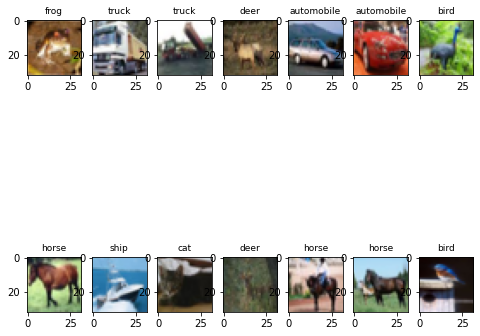

In [6]:
plt.figure(figsize=(8, 8)) 
for i in range(2*7):
    # define subplot
    plt.subplot(2, 7, i+1)
    plt.imshow(x_train [i])
    class_index = np.argmax(to_categorical(y_train[i], 10))
    plt.title(class_names[class_index], fontsize=9)

Convert Dataset in HD5 format

In [7]:
with h5py.File('dataset_cifar10.hdf5', 'w') as hf:
    dset_x_train = hf.create_dataset('x_train', data=x_train, shape=(50000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_train = hf.create_dataset('y_train', data=y_train, shape=(50000, 1), compression='gzip', chunks=True)
    dset_x_test = hf.create_dataset('x_valid', data=x_valid, shape=(10000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_test = hf.create_dataset('y_valid', data=y_valid, shape=(10000, 1), compression='gzip', chunks=True)

Create Model

In [8]:
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

Create a Data Generator

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
   
    def __init__(self, batch_size, test=False, shuffle=True):
       
        PATH_TO_FILE = 'dataset_cifar10.hdf5'
       
        self.hf = h5py.File(PATH_TO_FILE, 'r')         
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.on_epoch_end()

    def __del__(self):
        self.hf.close()
       
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start = self.batch_size * idx
        stop = self.batch_size * (idx+1)
       
        if self.test:
            x = self.hf['x_valid'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_valid'][start:stop]
            batch_y = to_categorical(np.array(y), 10)
        else:
            x = self.hf['x_train'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_train'][start:stop]
            batch_y = to_categorical(np.array(y), 10)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.test:
            self.indices = np.arange(self.hf['x_valid'][:].shape[0])
        else:
            self.indices = np.arange(self.hf['x_train'][:].shape[0])
           
        if self.shuffle:
            np.random.shuffle(self.indices)

In [13]:
batchsize  = 250 
data_train = DataGenerator(batch_size=batchsize)
data_valid = DataGenerator(batch_size=batchsize, test=True, shuffle=False)

Train the model on **CPU**

In [12]:
with tf.device('/device:CPU:0'):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    history = model.fit(data_train,epochs=10,
                        verbose=1, validation_data=data_valid)

Epoch 1/10
  6/200 [..............................] - ETA: 2:15 - loss: 2.2736 - accuracy: 0.1287

KeyboardInterrupt: ignored

Train the model on **GPU**

In [14]:
from tensorflow.keras.models import clone_model
new_model = clone_model(model)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  

In [15]:
%%time
with tf.device('/device:GPU:0'):
    new_history = new_model.fit(data_train,epochs=10,
                                verbose=1, validation_data=data_valid)

Epoch 1/10
200/200 [==============================] - 40s 140ms/step - loss: 1.6968 - accuracy: 0.3640 - val_loss: 1.3550 - val_accuracy: 0.5158
Epoch 2/10
200/200 [==============================] - 28s 142ms/step - loss: 1.2363 - accuracy: 0.5519 - val_loss: 1.0905 - val_accuracy: 0.6136
Epoch 3/10
200/200 [==============================] - 28s 139ms/step - loss: 1.0336 - accuracy: 0.6322 - val_loss: 0.9679 - val_accuracy: 0.6609
Epoch 4/10
200/200 [==============================] - 28s 139ms/step - loss: 0.8786 - accuracy: 0.6898 - val_loss: 0.8728 - val_accuracy: 0.6972
Epoch 5/10
200/200 [==============================] - 28s 138ms/step - loss: 0.7664 - accuracy: 0.7312 - val_loss: 0.8375 - val_accuracy: 0.7089
Epoch 6/10
200/200 [==============================] - 28s 138ms/step - loss: 0.6702 - accuracy: 0.7647 - val_loss: 0.8119 - val_accuracy: 0.7187
Epoch 7/10
200/200 [==============================] - 28s 138ms/step - loss: 0.5801 - accuracy: 0.7975 - val_loss: 0.7994 - val_ac